In [3]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rbm import RBM
from utils import get_label, remove_label, get_samples, create_folds, process_image, mean_squared_error, accuracy

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 30, 28
NUM_CLASSES = 10
FOLD_SIZE = 120

### Process MNIST Dataset for training/testing RBM model
#### Preprocessing Steps:
1. Convert images to binary
2. Add labels as pixels in the image

In [5]:
training_data   = pd.read_csv('mnist_train.csv', dtype=np.int16)
testing_data    = pd.read_csv('mnist_test.csv', dtype=np.int16)

In [6]:
folds = create_folds(training_data, fold_size=FOLD_SIZE)
folds = [np.apply_along_axis(lambda x: process_image(x, labeled=True), 1, fold) for fold in folds]

## Collect Learning/Validation Curves for varying training set sizes

In [11]:
# Collect learning/validation curves

mean_train_acc, mean_valid_acc = [], []
mean_train_mse, mean_valid_mse = [], []

std_train_acc, std_valid_acc = [], []
std_train_mse, std_valid_mse = [], []

training_sizes = np.arange(50, 550, 50)
for training_size in training_sizes:
    print(f'Training Size: {training_size}')
    train_mse, valid_mse = [], []
    train_acc, valid_acc = [], []
    for i in range(5):
        print(f'Fold {i+1}')

        # Get training samples from all other folds
        train = np.array([folds[j] for j in range(len(folds)) if i != j]).reshape(4*FOLD_SIZE, IMAGE_HEIGHT*IMAGE_WIDTH)[:training_size]
        
        # Get validation samples from this fold
        valid = folds[i]

        # Train RBM
        rbm = RBM(IMAGE_HEIGHT*IMAGE_WIDTH, 100)
        rbm.train(train)
        
        # Remove labels from training and validation data
        train_unlabeled = np.apply_along_axis(lambda x: remove_label(x), 1, train)
        valid_unlabeled = np.apply_along_axis(lambda x: remove_label(x), 1, valid)

        # Reconstruct training and validation data
        train_reconstructions = np.array(rbm.reconstruct(train_unlabeled, iters=5))
        valid_reconstructions = np.array(rbm.reconstruct(valid_unlabeled, iters=5))
        
        # Collect reconstruction error
        train_mse += [mean_squared_error(train, train_reconstructions)]
        valid_mse += [mean_squared_error(valid, valid_reconstructions)]

        # Collect Classification accuracy
        train_acc += [accuracy(train, train_reconstructions)]
        valid_acc += [accuracy(valid, valid_reconstructions)]
        
    print('='*50)
    mean_train_acc += [np.array(train_acc).mean()]
    mean_train_mse += [np.array(train_mse).mean()]
    std_train_acc  += [np.array(train_acc).std()]
    std_train_mse  += [np.array(train_mse).std()]

    mean_valid_acc += [np.array(valid_acc).mean()]
    mean_valid_mse += [np.array(valid_mse).mean()]
    std_valid_acc  += [np.array(valid_acc).std()]
    std_valid_mse  += [np.array(valid_mse).std()]


mean_train_acc = np.array(mean_train_acc)
mean_train_mse = np.array(mean_train_mse)
std_train_acc = np.array(std_train_acc)
std_train_mse = np.array(std_train_mse)

mean_valid_acc = np.array(mean_valid_acc)
mean_valid_mse = np.array(mean_valid_mse)
std_valid_acc = np.array(std_valid_acc)
std_valid_mse = np.array(std_valid_mse)

Training Size: 50
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 100
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 150
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 200
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 250
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 300
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 350
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 400
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 450
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Training Size: 500
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


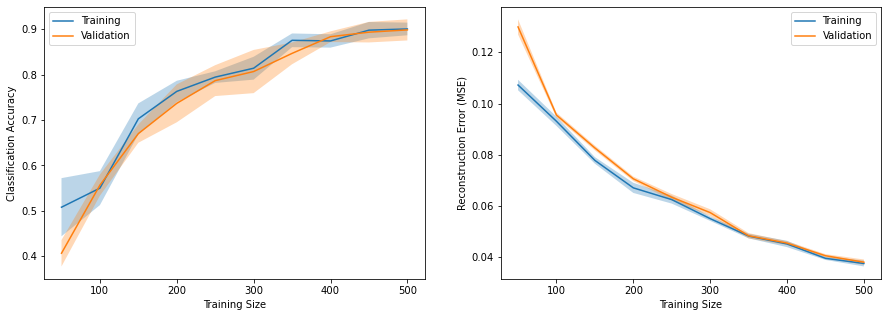

In [97]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(training_sizes, mean_train_acc, label='Training')
plt.fill_between(training_sizes, mean_train_acc-std_train_acc, mean_train_acc+std_train_acc, alpha=0.3)

plt.plot(training_sizes, mean_valid_acc, label='Validation')
plt.fill_between(training_sizes, mean_valid_acc-std_valid_acc, mean_valid_acc+std_valid_acc, alpha=0.3)

plt.xlabel('Training Size')
plt.ylabel('Classification Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_sizes, mean_train_mse, label='Training')
plt.fill_between(training_sizes, mean_train_mse-std_train_mse, mean_train_mse+std_train_mse, alpha=0.3)

plt.plot(training_sizes, mean_valid_mse, label='Validation')
plt.fill_between(training_sizes, mean_valid_mse-std_valid_mse, mean_valid_mse+std_valid_mse, alpha=0.3)

plt.xlabel('Training Size')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
# plt.show()

plt.savefig('training_size_experiment.png')

In [14]:
# Collect learning curves for varying hidden nodes

mean_train_acc2, mean_valid_acc2 = [], []
mean_train_mse2, mean_valid_mse2 = [], []

std_train_acc2, std_valid_acc2 = [], []
std_train_mse2, std_valid_mse2 = [], []


hidden_unit_opts = np.arange(50, 550, 50)
for num_hidden in hidden_unit_opts:
    print(f'# of Hidden Units: {num_hidden}')
    train_mse2, valid_mse2 = [], []
    train_acc2, valid_acc2 = [], []
    
    # Perform 5-fold cross validation for evaluating the hidden_unit_opts
    for i in range(5):
        print(f'Fold {i+1}')
        train = np.array([folds[j] for j in range(len(folds)) if i != j]).reshape(4*FOLD_SIZE, IMAGE_HEIGHT*IMAGE_WIDTH)
        valid = folds[i]

        # Train RBM
        rbm = RBM(IMAGE_HEIGHT*IMAGE_WIDTH, num_hidden)
        rbm.train(train)
        
        # Get reconstructions on training data and validation data
        train_unlabeled = np.apply_along_axis(lambda x: remove_label(x), 1, train)
        valid_unlabeled = np.apply_along_axis(lambda x: remove_label(x), 1, valid)

        train_reconstructions = np.array(rbm.reconstruct(train_unlabeled, iters=5))
        valid_reconstructions = np.array(rbm.reconstruct(valid_unlabeled, iters=5))
        
        # Collect reconstruction error
        train_mse2 += [mean_squared_error(train, train_reconstructions)]
        valid_mse2 += [mean_squared_error(valid, valid_reconstructions)]

        # Collect Classification accuracy
        train_acc2 += [accuracy(train, train_reconstructions)]
        valid_acc2 += [accuracy(valid, valid_reconstructions)]
    print('='*50)
    mean_train_acc2 += [np.array(train_acc2).mean()]
    mean_train_mse2 += [np.array(train_mse2).mean()]
    std_train_acc2  += [np.array(train_acc2).std()]
    std_train_mse2  += [np.array(train_mse2).std()]

    mean_valid_acc2 += [np.array(valid_acc2).mean()]
    mean_valid_mse2 += [np.array(valid_mse2).mean()]
    std_valid_acc2  += [np.array(valid_acc2).std()]
    std_valid_mse2  += [np.array(valid_mse2).std()]


mean_train_acc2 = np.array(mean_train_acc2)
mean_train_mse2 = np.array(mean_train_mse2)
std_train_acc2 = np.array(std_train_acc2)
std_train_mse2 = np.array(std_train_mse2)

mean_valid_acc2 = np.array(mean_valid_acc2)
mean_valid_mse2 = np.array(mean_valid_mse2)
std_valid_acc2 = np.array(std_valid_acc2)
std_valid_mse2 = np.array(std_valid_mse2)

# of Hidden Units: 50
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 100
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 150
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 200
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 250
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 300
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 350
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 400
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Hidden Units: 450
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


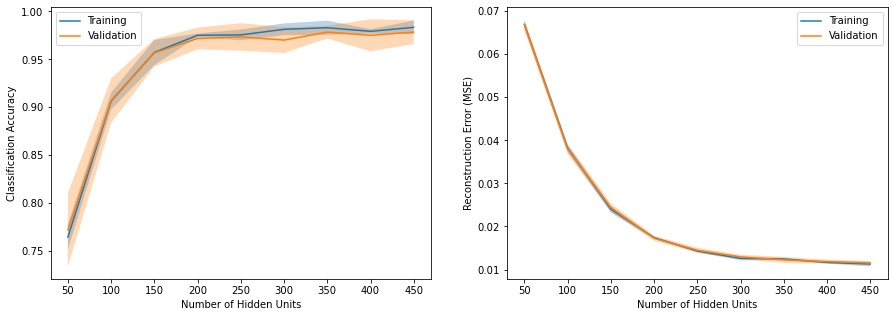

In [99]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hidden_unit_opts, mean_train_acc2, label='Training')
plt.fill_between(hidden_unit_opts, mean_train_acc2-std_train_acc2, mean_train_acc2+std_train_acc2, alpha=0.3)

plt.plot(hidden_unit_opts, mean_valid_acc2, label='Validation')
plt.fill_between(hidden_unit_opts, mean_valid_acc2-std_valid_acc2, mean_valid_acc2+std_valid_acc2, alpha=0.3)

plt.xlabel('Number of Hidden Units')
plt.ylabel('Classification Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hidden_unit_opts, mean_train_mse2, label='Training')
plt.fill_between(hidden_unit_opts, mean_train_mse2-std_train_mse2, mean_train_mse2+std_train_mse2, alpha=0.3)

plt.plot(hidden_unit_opts, mean_valid_mse2, label='Validation')
plt.fill_between(hidden_unit_opts, mean_valid_mse2-std_valid_mse2, mean_valid_mse2+std_valid_mse2, alpha=0.3)

plt.xlabel('Number of Hidden Units')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
# plt.show()

plt.savefig('hidden_units_experiment.png')


In [101]:
# Collect learning curves for varying hidden nodes

mean_train_acc3, mean_valid_acc3 = [], []
mean_train_mse3, mean_valid_mse3 = [], []

std_train_acc3, std_valid_acc3 = [], []
std_train_mse3, std_valid_mse3 = [], []


gibbs_sampling_opts = np.arange(1, 11, 1)
for gibbs_steps in gibbs_sampling_opts:
    print(f'# of Gibbs Steps: {gibbs_steps}')
    train_mse3, valid_mse3 = [], []
    train_acc3, valid_acc3 = [], []
    for fold in range(5):
        print(f'Fold {fold+1}')
        # Get training samples for this fold
        train = np.array([folds[j] for j in range(len(folds)) if i != j]).reshape(4*FOLD_SIZE, IMAGE_HEIGHT*IMAGE_WIDTH)
        valid = folds[i]


        # Train RBM
        rbm = RBM(IMAGE_HEIGHT*IMAGE_WIDTH, 100)
        rbm.train(train, epochs=5)
        
        # Get reconstructions on training data and validation data
        train_reconstructions = np.array(rbm.reconstruct(train, iters=5))
        valid_reconstructions = np.array(rbm.reconstruct(valid, iters=5))
        
        # Collect reconstruction error
        train_mse3 += [mean_squared_error(train, train_reconstructions)]
        valid_mse3 += [mean_squared_error(valid, valid_reconstructions)]

        # Collect Classification accuracy
        train_acc3 += [accuracy(train, train_reconstructions)]
        valid_acc3 += [accuracy(valid, valid_reconstructions)]
    print('='*50)
    mean_train_acc3 += [np.array(train_acc3).mean()]
    mean_train_mse3 += [np.array(train_mse3).mean()]
    std_train_acc3  += [np.array(train_acc3).std()]
    std_train_mse3  += [np.array(train_mse3).std()]

    mean_valid_acc3 += [np.array(valid_acc3).mean()]
    mean_valid_mse3 += [np.array(valid_mse3).mean()]
    std_valid_acc3  += [np.array(valid_acc3).std()]
    std_valid_mse3  += [np.array(valid_mse3).std()]


mean_train_acc3 = np.array(mean_train_acc3)
mean_train_mse3 = np.array(mean_train_mse3)
std_train_acc3 = np.array(std_train_acc3)
std_train_mse3 = np.array(std_train_mse3)

mean_valid_acc3 = np.array(mean_valid_acc3)
mean_valid_mse3 = np.array(mean_valid_mse3)
std_valid_acc3 = np.array(std_valid_acc3)
std_valid_mse3 = np.array(std_valid_mse3)

# of Gibbs Steps: 1
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 2
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 3
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 4
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 5
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 6
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 7
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 8
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 9
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
# of Gibbs Steps: 10
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


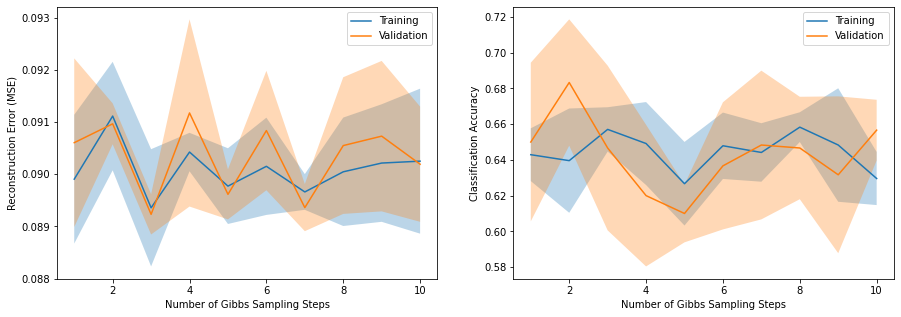

In [102]:
plt.figure(1, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(gibbs_sampling_opts, mean_train_mse3, label='Training')
plt.fill_between(gibbs_sampling_opts, mean_train_mse3-std_train_mse3, mean_train_mse3+std_train_mse3, alpha=0.3)

plt.plot(gibbs_sampling_opts, mean_valid_mse3, label='Validation')
plt.fill_between(gibbs_sampling_opts, mean_valid_mse3-std_valid_mse3, mean_valid_mse3+std_valid_mse3, alpha=0.3)

plt.xlabel('Number of Gibbs Sampling Steps')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gibbs_sampling_opts, mean_train_acc3, label='Training')
plt.fill_between(gibbs_sampling_opts, mean_train_acc3-std_train_acc3, mean_train_acc3+std_train_acc3, alpha=0.3)

plt.plot(gibbs_sampling_opts, mean_valid_acc3, label='Validation')
plt.fill_between(gibbs_sampling_opts, mean_valid_acc3-std_valid_acc3, mean_valid_acc3+std_valid_acc3, alpha=0.3)

plt.xlabel('Number of Gibbs Sampling Steps')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()

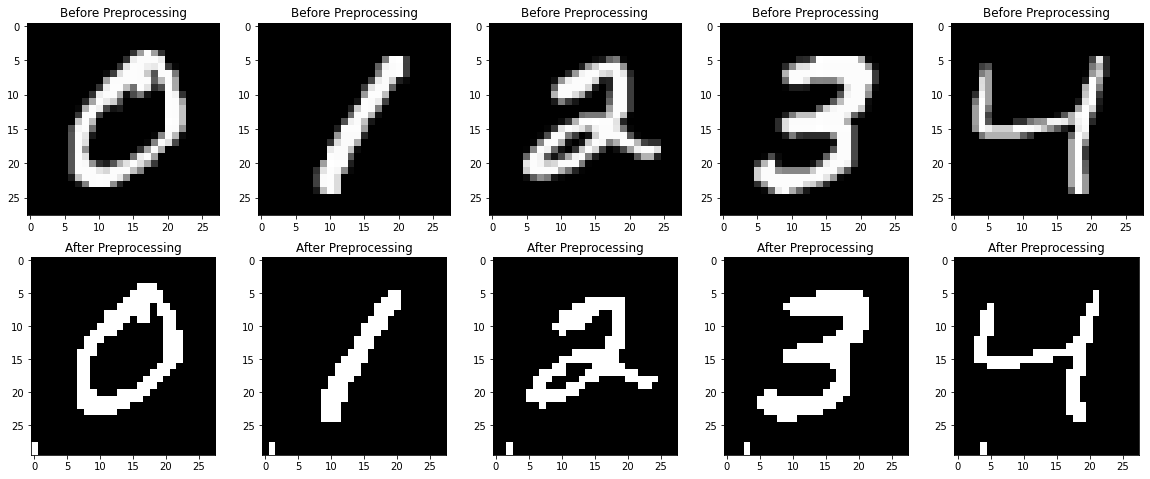

In [7]:
before = [get_samples(training_data, i, 1)[0] for i in range(5)]
after  = [process_image(image) for image in before]

_, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    
    axs[0, i].set_title('Before Preprocessing')
    axs[0, i].imshow(before[i][1:].reshape(IMAGE_HEIGHT-2, IMAGE_WIDTH), cmap='gray')
    axs[1, i].set_title('After Preprocessing')
    axs[1, i].imshow(after[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray');
    # plt.axis('off')
plt.savefig('processing.png')
# plt.show()

In [68]:
training = np.array([get_samples(training_data, label, 200) for label in range(10)]).reshape(2000, 785)
training = np.apply_along_axis(lambda x: process_image(x, labeled=True), 1, training)

testing  = np.array([get_samples(testing_data, label, 1) for label in range(10)]).reshape(10, 785)
testing  = np.apply_along_axis(lambda x: process_image(x, labeled=True), 1, testing)
testing  = np.apply_along_axis(lambda x: remove_label(x), 1, testing)


In [74]:
rbm_final = RBM(IMAGE_HEIGHT*IMAGE_WIDTH, 500)
rbm_final.train(training)

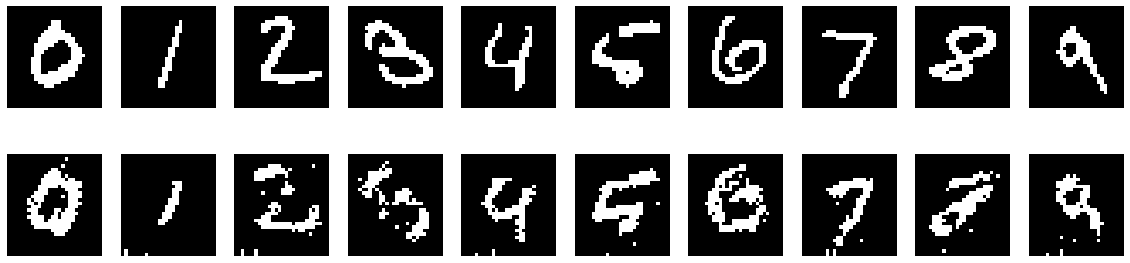

In [75]:
fig, axs = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    img = testing[i]
    reconstruction = rbm_final.reconstruct([img], iters=10)[0]
    axs[0, i].imshow(img.reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    axs[1, i].imshow(reconstruction.reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

# plt.savefig('reconstructions.png')
plt.show()